## ASTR 21000, Winter 2020

## Quasar - Star - Galaxy separation: an ML approach using data from SDSS DR 15

### by Dimitrios Tanaglidis

**Background:** One important task in current and future astronomical surveys is to separate the surveyed objects into (mainly) stars and galaxies and also to a special category of very active galaxies known as quasars. 

Usually in these large astronomical surveys we are interested in having a pure sample of galaxies (thus stars act more like a nuisance) to use for cosmological analyses. In some cases we are also interested in a quasar catalog for studies of that particular galaxy population.

In this notebook we use data from the 15th data release (DR 15) of SDSS to classify objects into the three categories (QSO, Star, Galaxy) based on their photometric properties (flux, that is light intensities, in the filters $u,g,r,i,z$) and derivative quantities. The csv data file can be downloaded from <a href="https://uchicago.box.com/s/d6bsazwpvfyhmmrwi2mqgut29rfiasq7">here</a>. 

In some cases we we also use the redshift information (redshift shows, in some sense, the distance to the object); however since this is not always available, we'll try to minimize its use. 

In [2]:
#Import stuff
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import pandas as pd
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [4]:
# Import the 
SDSS_table = pd.read_csv("data/MyTable_0_dtanoglidis_2.csv")
SDSS_table.head()

,objid,ra,dec,u,g,r,i,z,specobjid,class,redshift
0,1237646798137787517,121.802126,0.855476,25.02634,21.90814,20.17926,19.22341,18.68446,5342652717419438080,GALAXY,0.504717
1,1237646798137787833,121.748271,0.891010,23.74677,22.75365,21.10284,20.06169,19.50690,5342652167663624192,GALAXY,0.579273
2,1237646798137788079,121.708487,0.874751,23.15607,22.95075,20.89328,19.71096,19.10471,5342651617907810304,GALAXY,0.772647
3,1237646798137852371,121.820752,0.931990,19.37035,17.34262,16.35286,15.92400,15.58903,5342663162779901952,GALAXY,0.101993
4,1237646798137852646,121.910430,0.896389,23.42736,22.81119,20.27570,19.14886,18.67588,5342662613024088064,GALAXY,0.585733


In [3]:
# Get the redshift
redshift = SDSS_table["redshift"]
# Get the magnitudes
u = SDSS_table["u"];g = SDSS_table["g"];r = SDSS_table["r"];i = SDSS_table["i"];z =SDSS_table["z"]
class_obs = SDSS_table["class"]

class_label = np.zeros(len(class_obs))

Now change the class of objects to something that a machine can understand. Say "GALAXY" = 0, "STAR" = 1, "QSO"=2

In [4]:
for i_l in range(len(class_label)):
    
    if (class_obs[i_l]=="GALAXY"):
        class_label[i_l] = 0
    elif (class_obs[i_l]=="STAR"):
        class_label[i_l] = 1
    else:
        class_label[i_l] = 2

Perform some cuts now. Reject all objects with any of the magnitudes smaller than $-10$,

In [5]:
cuts = (u>-10.)&(g>-10.)&(r>-10.0)&(i>-10.0)&(z>-10.0)

u = u[cuts]
g = g[cuts]
r = r[cuts]
i = i[cuts]
z = z[cuts]
redshift = redshift[cuts]
class_label = class_label[cuts]
print(len(redshift))

299908


Let's see how many we have from each category.

In [6]:
print(len(redshift[class_label==0]))
print(len(redshift[class_label==1]))
print(len(redshift[class_label==2]))

184535
73228
42145


So, we have 184535 galaxies, 73228 stars and 42145 QSOs. We should be careful about this class imbalance later on...


Now let's create some extra features, beyond the raw magnitudes we imported above. Namely the colors and the magnitude ratios.

The colors are $u-g$, $u-r$, $u-i$, $u-z$, $g-r$, $g-i$, $g-z$, $r-i$, $r-z$ 

And the ratios, similarly: $u/g$, $u/r$, $u/i$, $u/z$, $g/r$, $g/i$, $g/z$, $r/i$, $r/z$.

In [7]:
# Define colors first 
u_g = u-g; u_r = u-r; u_i = u-i; u_z = u-z; g_r = g-r; g_i = g-i; g_z = g-z; r_i = r-i; r_z = r-z
# Define the rations now
u_ov_g = u/g; u_ov_r = u/r; u_ov_i = u/i; u_ov_z = u/z; g_ov_r = g/r; g_ov_i = g/i; g_ov_z=g/z; r_ov_i = r/i
r_ov_z = r/z 

Now create an instance matrix.

In [8]:
n_feat = len(redshift)

# Initialize feature matrix
X_feat = np.zeros([n_feat,23])
# ================================================================
# ================================================================
# Define feature matrix
X_feat[:,0] = u;X_feat[:,1] = g; X_feat[:,2] = r; X_feat[:,3] = i; X_feat[:,4] =z
X_feat[:,5] = u_g;X_feat[:,6] = u_r;X_feat[:,7] = u_i;X_feat[:,8] = u_z; X_feat[:,9] = g_r
X_feat[:,10] = g_i; X_feat[:,11] = g_z; X_feat[:,12] = r_i; X_feat[:,13] = r_z
X_feat[:,14] = u_ov_g; X_feat[:,15] = u_ov_r; X_feat[:,16] = u_ov_i; X_feat[:,17] = u_ov_z
X_feat[:,18] = g_ov_r;X_feat[:,19] = g_ov_i;X_feat[:,20] = g_ov_z; X_feat[:,21] = r_ov_i; X_feat[:,22] = r_ov_z

Now let's standardize the dataset. 

In [9]:
from sklearn.preprocessing import StandardScaler

X_ft_stand = StandardScaler().fit_transform(X_feat)
print(X_ft_stand)

[[1.39549857 0.83371763 0.55497318 ... 1.04837323 0.86329532 0.90882436]
 [0.84795138 1.24334718 1.06334899 ... 0.95621801 0.95550779 0.9590267 ]
 [0.59518199 1.33883745 0.94799868 ... 1.48378129 1.29842992 1.28612867]
 ...
 [0.49437806 0.51393906 0.29072322 ... 0.81659708 0.56992166 0.71080943]
 [1.03865598 0.55028447 0.17304456 ... 0.86333132 0.17022859 0.36295734]
 [1.77005684 0.94521016 0.80770792 ... 0.74675703 0.75056456 0.75657329]]


### Part I: Exploratory data analysis: t-SNE and PCA visualizations

Here I apply two commonly used dimensionality reduction techniques to vizualize the 23-dimensional feature space we created above.

First I will use t-distributed stochastic neighbor embedding (t-SNE), a popular dimensionality reduction algorithm that allows to meaningfully project/vizualise a multidimensional feature space into an abstract lower-dimensional space (2-d or 3-d).

Then I will perform the very commonly employed Principal Components Analysis (PCA) and project the 23-dimensional feature space into the space of the first two or three most important principal components.

#### t-SNE

In [10]:
from sklearn.manifold import TSNE
X_tsne_2 = TSNE(n_components=2).fit_transform(X_ft_stand[:10000,:])
X_tsne_3 =  TSNE(n_components=3).fit_transform(X_ft_stand[:10000,:])
y_tsne = class_label[:10000]

Make plots now.

- First, start in 2d

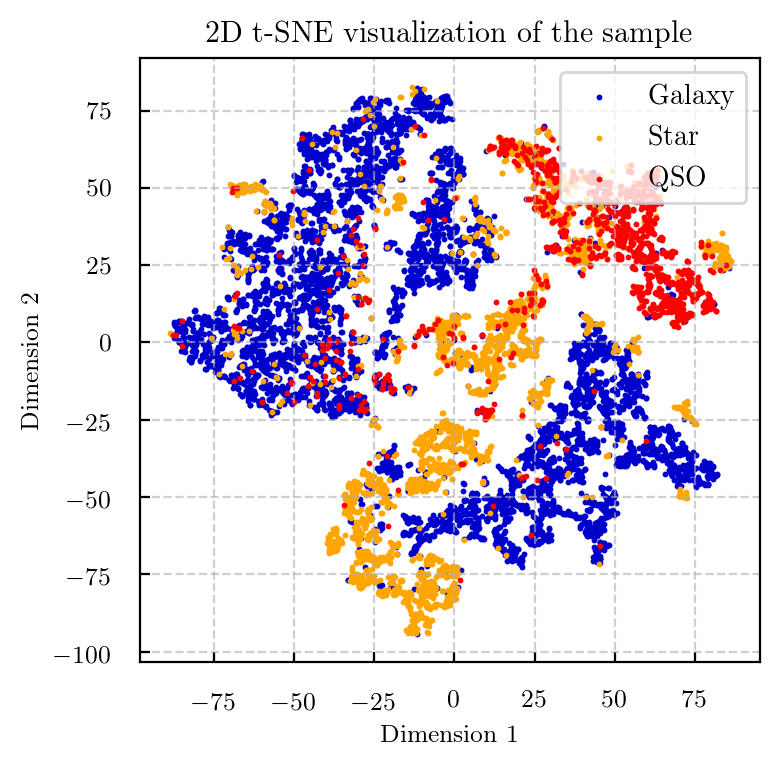

In [11]:
ft_1 = X_tsne_2[:,0]
ft_2 = X_tsne_2[:,1]

plt.figure(figsize = (4.0,4.0))

plt.scatter(ft_1[y_tsne==0],ft_2[y_tsne==0], s=1.2, color='mediumblue', label='Galaxy')
plt.scatter(ft_1[y_tsne==1],ft_2[y_tsne==1], s=1.2, color='orange', label='Star')
plt.scatter(ft_1[y_tsne==2],ft_2[y_tsne==2], s=1.2, color='red', label='QSO')

plt.grid(ls='--', alpha=0.6)
plt.xlabel('Dimension 1');plt.ylabel('Dimension 2')
plt.title('2D t-SNE visualization of the sample')

plt.legend(frameon=True, loc='upper right', fontsize=10)
plt.show()

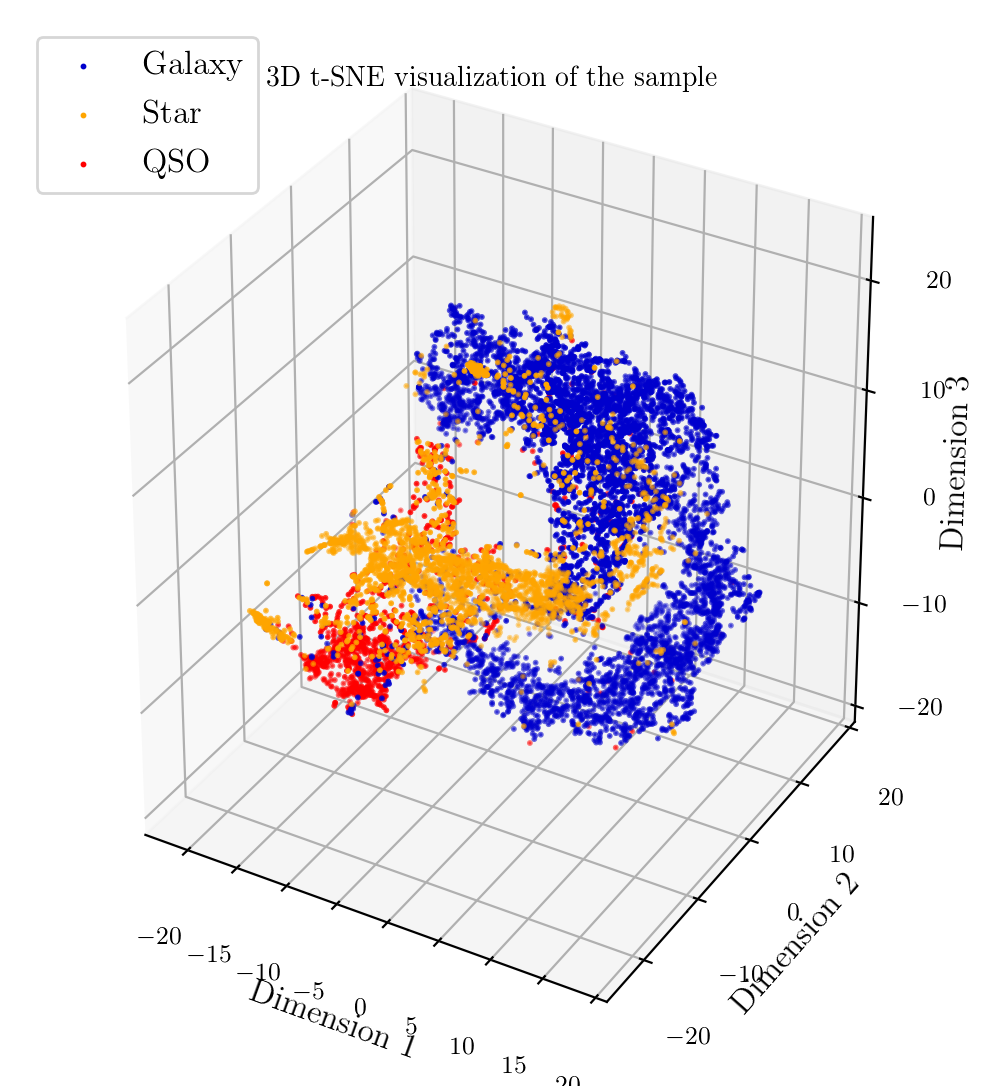

In [12]:
ft_1 = X_tsne_3[:,0]
ft_2 = X_tsne_3[:,1]
ft_3 = X_tsne_3[:,2]

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (5,5.5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ft_1[y_tsne==0],ft_2[y_tsne==0],ft_3[y_tsne==0], s=1.2, color='mediumblue', label='Galaxy')
ax.scatter(ft_1[y_tsne==1],ft_2[y_tsne==1],ft_3[y_tsne==1], s=1.2, color='orange', label='Star')
ax.scatter(ft_1[y_tsne==2],ft_2[y_tsne==2],ft_3[y_tsne==2], s=1.2, color='red', label='QSO')

ax.set_title('3D t-SNE visualization of the sample',fontsize=10)
ax.set_xlabel('Dimension 1', fontsize=12)
ax.set_ylabel('Dimension 2', fontsize=12)
ax.set_zlabel('Dimension 3', fontsize=12)


plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


#### PCA

Now perform a Singular Value Decomposition on the feature matrix X.

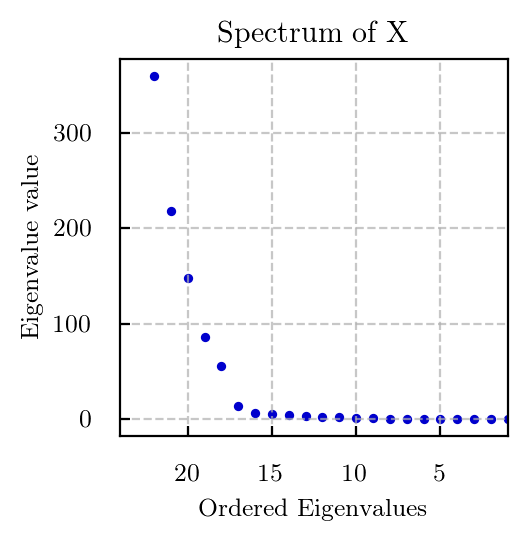

In [13]:
U,S,V_T = np.linalg.svd(X_ft_stand[:10000,:], full_matrices=True)

plt.figure(figsize = (2.5,2.5))


plt.scatter(range(23),np.sort(S),color="mediumblue",s=5.5)
plt.xlabel("Ordered Eigenvalues")
plt.ylabel("Eigenvalue value")

plt.title("Spectrum of X")

plt.xlim(24,1)
plt.grid(ls='--',alpha=0.7)
plt.show()

We see that the first $\sim 8$ principal components are very important.

In [14]:
coords_custs = np.zeros([10000,3]) # This matrix will store the coordinates in the reduced 2-d space

V = V_T.T

V_1 = V[:,0] # First principal component
V_2 = V[:,1] # Second princial component
V_3 = V[:,2] # Third principal component

for i in range(10000):
    vect = X_ft_stand[i,:]
    
    # Coord in first p.c.
    coords_custs[i,0] = np.dot(vect,V_1)
    # Coord in second p.c.
    coords_custs[i,1] = np.dot(vect, V_2)
    # Coord in third p.c.
    coords_custs[i,2] = np.dot(vect, V_3)   

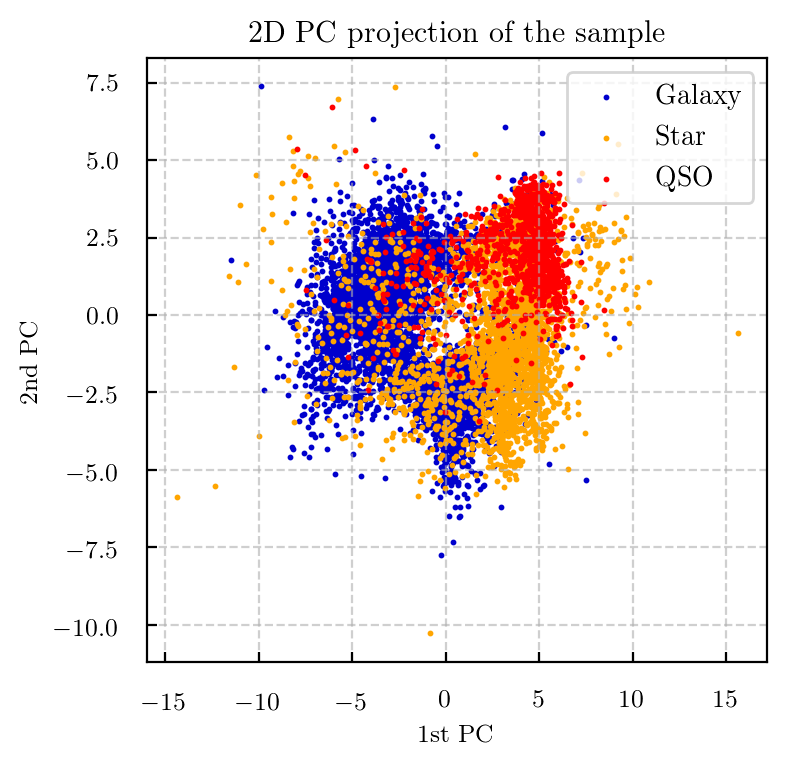

In [15]:
ft_1 = coords_custs[:,0]
ft_2 = coords_custs[:,1]
ft_3 = coords_custs[:,2]

plt.figure(figsize = (4.0,4.0))

plt.scatter(ft_1[y_tsne==0],ft_2[y_tsne==0], s=1.2, color='mediumblue', label='Galaxy')
plt.scatter(ft_1[y_tsne==1],ft_2[y_tsne==1], s=1.2, color='orange', label='Star')
plt.scatter(ft_1[y_tsne==2],ft_2[y_tsne==2], s=1.2, color='red', label='QSO')

plt.grid(ls='--', alpha=0.6)
plt.xlabel('1st PC');plt.ylabel('2nd PC')
plt.title('2D PC projection of the sample')

plt.legend(frameon=True, loc='upper right', fontsize=10)
plt.show()

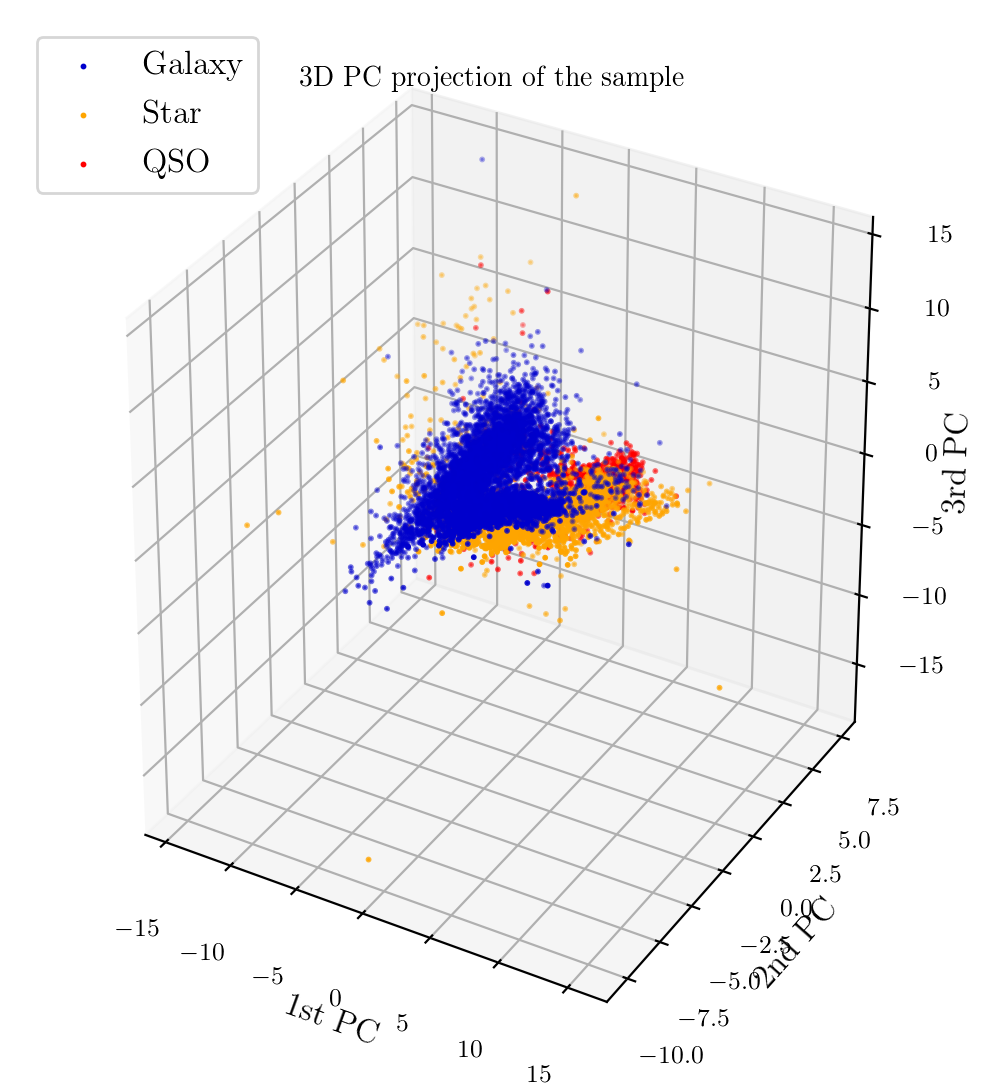

In [16]:
fig = plt.figure(figsize = (5,5.5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ft_1[y_tsne==0],ft_2[y_tsne==0],ft_3[y_tsne==0], s=1.2, color='mediumblue', label='Galaxy')
ax.scatter(ft_1[y_tsne==1],ft_2[y_tsne==1],ft_3[y_tsne==1], s=1.2, color='orange', label='Star')
ax.scatter(ft_1[y_tsne==2],ft_2[y_tsne==2],ft_3[y_tsne==2], s=1.2, color='red', label='QSO')

ax.set_title('3D PC projection of the sample',fontsize=10)
ax.set_xlabel('1st PC', fontsize=12)
ax.set_ylabel('2nd PC', fontsize=12)
ax.set_zlabel('3rd PC', fontsize=12)


plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

### Part II: Classification

Now that we have seen, by projecting our dataset to lower dimensional spaces, that the three types of objects are, although imperfectly, separable we will use standard Supervised Learning classification techniques to classify them.

We will try:

- Random Forrest classification.
- Support vector Machine classification.
- XGBoost 
- Neural Nets.

We'll start by presenting a three-categories classification but later on we'll also explore just star-galaxy and QSO vs the rest classification.


First let's split the total dataset into training and test set.

In [17]:
from sklearn.model_selection import train_test_split
X_ft_stand_r = X_ft_stand[:100000,:]
class_label_r = class_label[:100000]
X_train, X_test, y_train, y_test = train_test_split(X_ft_stand_r, class_label_r, train_size = 0.70, random_state = 42)

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


####  Random Forrest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


RF_cl = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                               min_samples_split=2, min_samples_leaf=1)

In [19]:
param_grid = {'n_estimators': [10, 100, 150],
              'min_samples_split': [2,5,10]}

grid = GridSearchCV(RF_cl, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 13min 33s, sys: 11.5 s, total: 13min 45s
Wall time: 14min 41s
{'min_samples_split': 5, 'n_estimators': 150}


In [20]:
# Redefine the classifier
RF_cl = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=None,
                               min_samples_split=5, min_samples_leaf=1)

# fit 
RF_cl.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
# predict now on the test set
y_pred = RF_cl.predict(X_test)

Let's calculate the accuracy score now

In [22]:
from sklearn.metrics import accuracy_score

acc_RF = accuracy_score(y_test, y_pred)

print(acc_RF)

0.9066


We have $\sim 90\%$ accuracy on the test set.

Let's plot the confusion matrix now.

In [23]:
from sklearn.metrics import confusion_matrix


con_mat = confusion_matrix(y_test, y_pred).T
con_mat = con_mat.astype(float)
class_names = ['Galaxy', 'Star', 'QSO']

norm_1 = np.sum(con_mat[0,:])
norm_2 = np.sum(con_mat[1,:])
norm_3 = np.sum(con_mat[2,:])

con_mat[0,:] = con_mat[0,:]/np.float(norm_1)
con_mat[1,:] = con_mat[1,:]/np.float(norm_2)
con_mat[2,:] = con_mat[2,:]/np.float(norm_3)


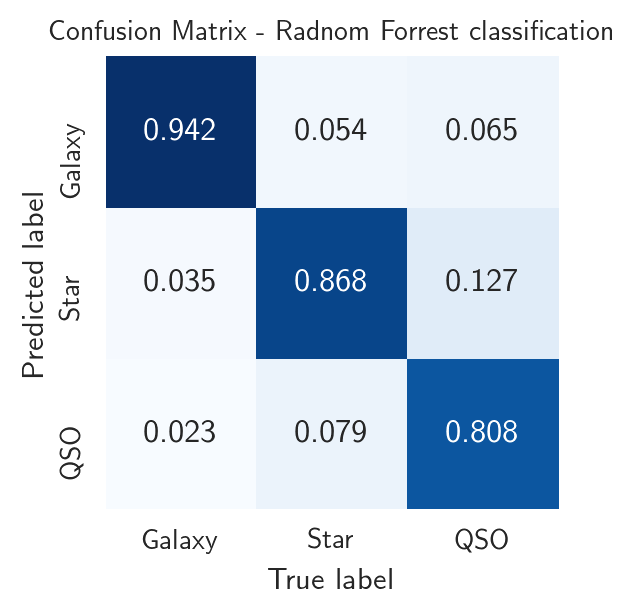

In [24]:
import seaborn as sns

plt.figure(figsize = (3.0,3.0))
plt.title('Confusion Matrix - Radnom Forrest classification',fontsize=10)
sns.heatmap(con_mat.T, square = True, annot=True, fmt='.3f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

Feature ranking:
1. feature 21 (0.129597)
2. feature 22 (0.098035)
3. feature 12 (0.089354)
4. feature 20 (0.056881)
5. feature 13 (0.056844)
6. feature 19 (0.054884)
7. feature 10 (0.041014)
8. feature 11 (0.040657)
9. feature 5 (0.040302)
10. feature 6 (0.038702)
11. feature 18 (0.038487)
12. feature 14 (0.038223)
13. feature 15 (0.033805)
14. feature 9 (0.030217)
15. feature 16 (0.028664)
16. feature 17 (0.028578)
17. feature 7 (0.025186)
18. feature 4 (0.024288)
19. feature 3 (0.023851)
20. feature 8 (0.021504)
21. feature 2 (0.021500)
22. feature 1 (0.020383)
23. feature 0 (0.019044)


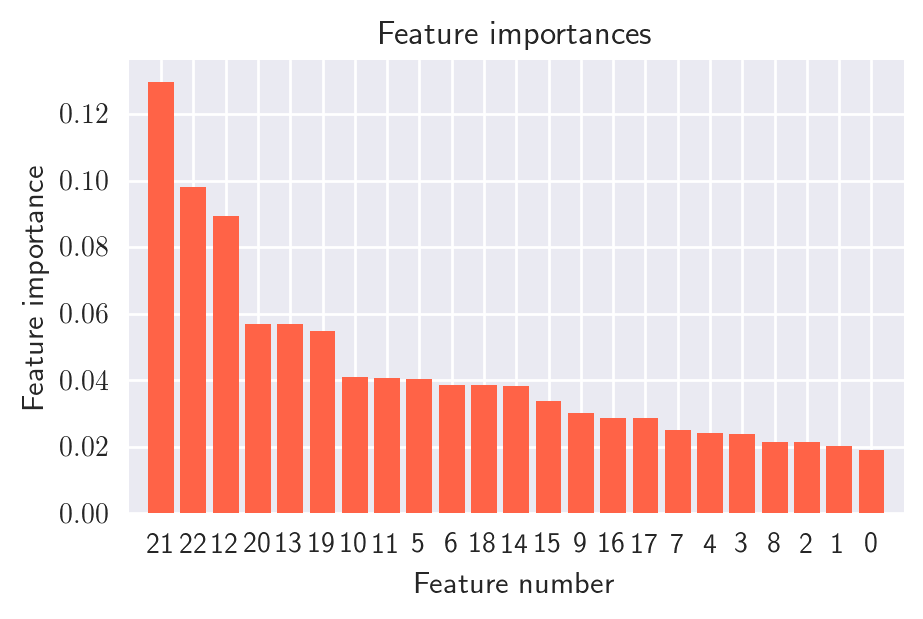

In [25]:
importances = RF_cl.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(5,3))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="tomato",  align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])

plt.xlabel('Feature number')
plt.ylabel('Feature importance')
plt.show()

We see that the most important features are the magnitude ratios.


#### Support Vector Machine (SVM) classification

In [26]:
from sklearn.svm import SVC 
svm_1 = SVC(kernel='rbf',class_weight='balanced')
param_grid = {'C': [0.01, 1, 10, 100],
              'gamma': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(svm_1, param_grid)

%time grid.fit(X_train[:1000,:], y_train[:1000])
print(grid.best_params_)

CPU times: user 1.53 s, sys: 19.4 ms, total: 1.55 s
Wall time: 1.59 s
{'C': 100, 'gamma': 0.01}


//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
svm_c = SVC(C=100,kernel='rbf',gamma=0.01,class_weight='balanced')

# Fit 
# fit 
svm_c.fit(X_train,y_train)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
# Predict
y_pred = svm_c.predict(X_test)
acc_SVM = accuracy_score(y_test, y_pred)

print(acc_SVM)

0.8828666666666667


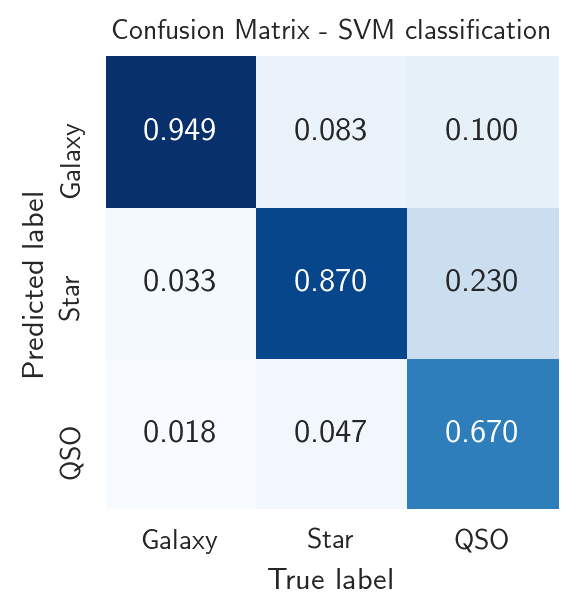

In [29]:
con_mat = confusion_matrix(y_test, y_pred).T
con_mat = con_mat.astype(float)
class_names = ['Galaxy', 'Star', 'QSO']

norm_1 = np.sum(con_mat[0,:])
norm_2 = np.sum(con_mat[1,:])
norm_3 = np.sum(con_mat[2,:])

con_mat[0,:] = con_mat[0,:]/np.float(norm_1)
con_mat[1,:] = con_mat[1,:]/np.float(norm_2)
con_mat[2,:] = con_mat[2,:]/np.float(norm_3)

plt.figure(figsize = (3.0,3.0))
plt.title('Confusion Matrix - SVM classification',fontsize=10)
sns.heatmap(con_mat.T, square = True, annot=True, fmt='.3f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

#### XGBoost

In [30]:
from xgboost import XGBClassifier

XGBCmodel = XGBClassifier(max_depth=3, learning_rate=1, n_estimators=150)
XGBCmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
y_pred = XGBCmodel.predict(X_test)
acc_XGB = accuracy_score(y_test, y_pred)
print(acc_XGB)

0.8981333333333333


In [32]:
con_mat = confusion_matrix(y_test, y_pred).T
con_mat = con_mat.astype(float)
class_names = ['Galaxy', 'Star', 'QSO']

norm_1 = np.sum(con_mat[0,:])
norm_2 = np.sum(con_mat[1,:])
norm_3 = np.sum(con_mat[2,:])

con_mat[0,:] = con_mat[0,:]/np.float(norm_1)
con_mat[1,:] = con_mat[1,:]/np.float(norm_2)
con_mat[2,:] = con_mat[2,:]/np.float(norm_3)

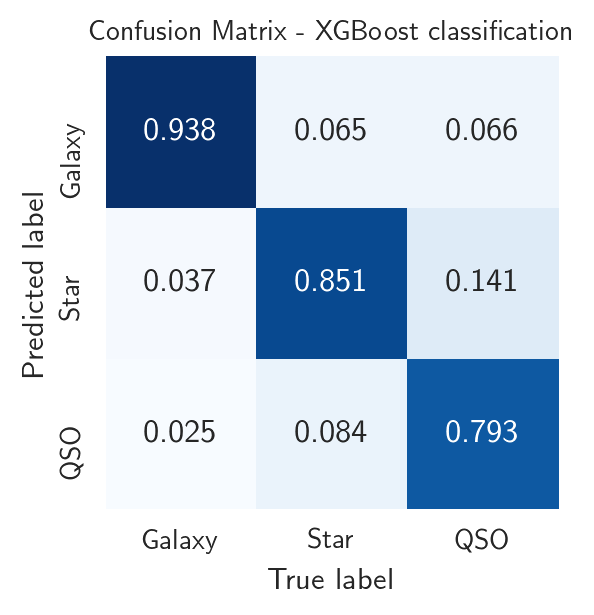

In [33]:
plt.figure(figsize = (3.0,3.0))
plt.title('Confusion Matrix - XGBoost classification',fontsize=10)
sns.heatmap(con_mat.T, square = True, annot=True, fmt='.3f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

#### Artificial Neural Nets

In [34]:
import tensorflow as tf
from tensorflow import keras
#from keras import to_categorical

y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

Build the ANN model

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(32, input_dim=23, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(units=3, activation='softmax'))
model.compile(optimizer=tf.train.AdadeltaOptimizer(0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [36]:
model.fit(x=X_train, y=y_train_cat,
          epochs=18, batch_size=16,
          shuffle=True)

Epoch 1/18
70000/70000 [==============================]70000/70000 [==============================] - 16s 232us/step - loss: 0.5892 - acc: 0.7851

In [37]:
y_pred = model.predict_classes(X_test)
acc_NN = accuracy_score(y_test, y_pred)
print(acc_NN)

0.8887


In [38]:
con_mat = confusion_matrix(y_test, y_pred).T
con_mat = con_mat.astype(float)
class_names = ['Galaxy', 'Star', 'QSO']

norm_1 = np.sum(con_mat[0,:])
norm_2 = np.sum(con_mat[1,:])
norm_3 = np.sum(con_mat[2,:])

con_mat[0,:] = con_mat[0,:]/np.float(norm_1)
con_mat[1,:] = con_mat[1,:]/np.float(norm_2)
con_mat[2,:] = con_mat[2,:]/np.float(norm_3)

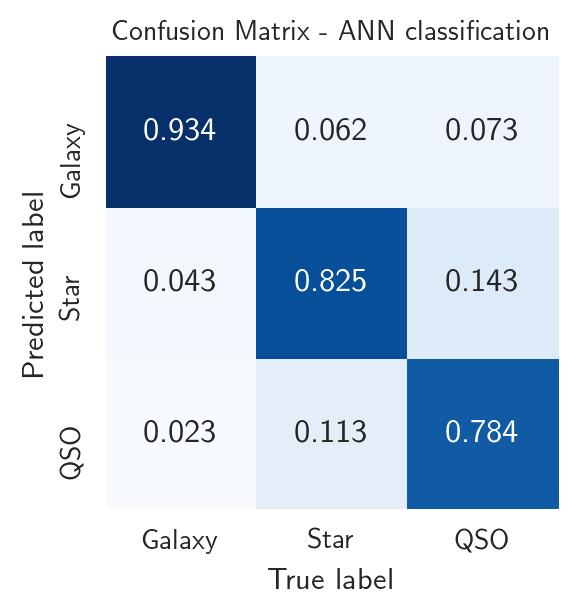

In [39]:
plt.figure(figsize = (3.0,3.0))
plt.title('Confusion Matrix - ANN classification',fontsize=10)
sns.heatmap(con_mat.T, square = True, annot=True, fmt='.3f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

### Part III: Star - Galaxy separation.

Here we explore just the Star-Galaxy separation, using Random Forrests.

In [40]:
# First, keep only 
X_ft_new = X_ft_stand_r[(class_label_r==0.0)|(class_label_r==1.0),:]
y_label_new = class_label_r[(class_label_r==0.0)|(class_label_r==1.0)]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_ft_new, y_label_new, train_size = 0.70, random_state = 42)

In [41]:
# fit 
RF_cl.fit(X_train2,y_train2)
y_pred = RF_cl.predict(X_test2)
acc_RF = accuracy_score(y_test2, y_pred)

In [42]:
print(acc_RF)

0.9547036979730775


In [43]:
con_mat = confusion_matrix(y_test2, y_pred).T
con_mat = con_mat.astype(float)
class_names = ['Galaxy', 'Star']

norm_1 = np.sum(con_mat[0,:])
norm_2 = np.sum(con_mat[1,:])

con_mat[0,:] = con_mat[0,:]/np.float(norm_1)
con_mat[1,:] = con_mat[1,:]/np.float(norm_2)


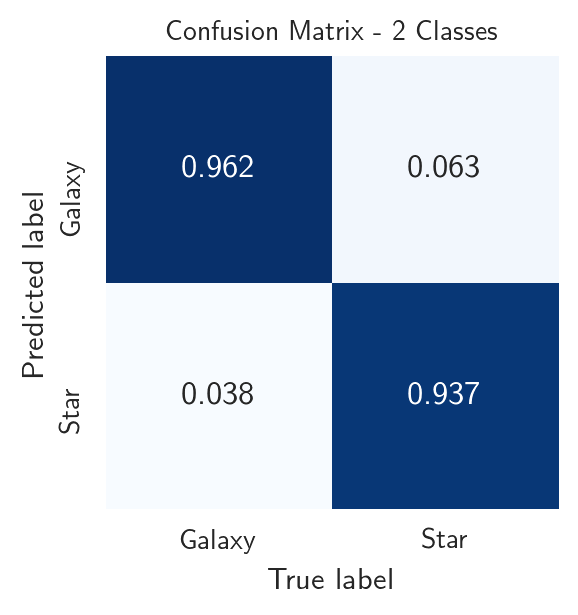

In [44]:
plt.figure(figsize = (3.0,3.0))
plt.title('Confusion Matrix - 2 Classes',fontsize=10)
sns.heatmap(con_mat.T, square = True, annot=True, fmt='.3f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

##### Receiver Operating Characteristic (ROC) curve

In [45]:
from sklearn import metrics
scores = RF_cl.predict_proba(X_test2)
fpr, tpr, thresholds = metrics.roc_curve(y_test2, scores[:,0], pos_label=0.0)


from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test2, scores[:,0]))

0.015477454305159136


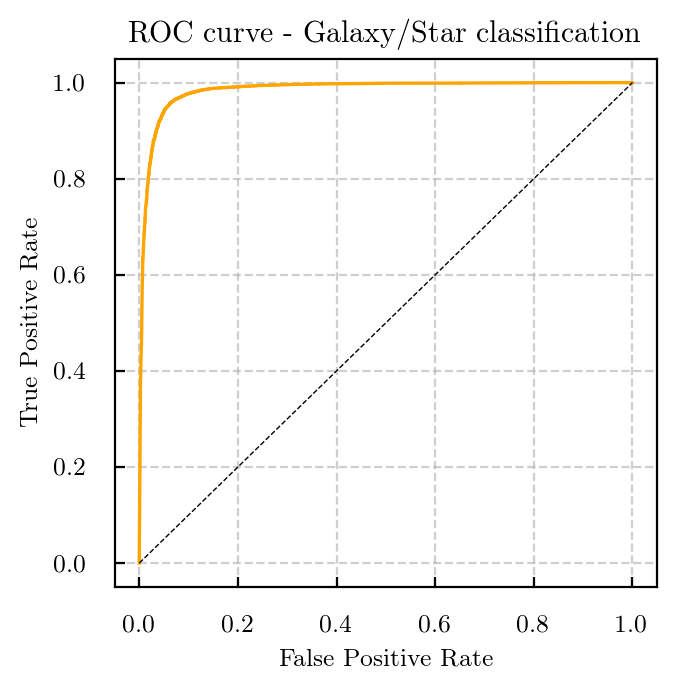

In [46]:
sns.reset_orig()
plot_pretty()
x = np.linspace(0,1,100)
plt.figure(figsize = (3.5,3.5))

plt.plot(fpr,tpr,c='orange',linewidth=1.2)
plt.plot(x,x, c='k',ls='--',linewidth=0.5)
plt.grid(ls='--', alpha=0.6)

plt.title('ROC curve - Galaxy/Star classification')
plt.xlabel('False Positive Rate');plt.ylabel('True Positive Rate')
plt.show()